# Pretrained ResNet on MIT Indoor Scene Recognition - Load Model Test 


In [2]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

## 1. Prepare Device

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [4]:
device = get_default_device()
device

device(type='cpu')

## 2. Prepare Dataset

In [5]:
!ls ../../data/indoorCVPR_09/Images

airport_inside	computerroom	     inside_subway   pantry
artstudio	concert_hall	     jewelleryshop   poolinside
auditorium	corridor	     kindergarden    prisoncell
bakery		deli		     kitchen	     restaurant
bar		dentaloffice	     laboratorywet   restaurant_kitchen
bathroom	dining_room	     laundromat      shoeshop
bedroom		elevator	     library	     stairscase
bookstore	fastfood_restaurant  livingroom      studiomusic
bowling		florist		     lobby	     subway
buffet		gameroom	     locker_room     toystore
casino		garage		     mall	     trainstation
children_room	greenhouse	     meeting_room    tv_studio
church_inside	grocerystore	     movietheater    videostore
classroom	gym		     museum	     waitingroom
cloister	hairsalon	     nursery	     warehouse
closet		hospitalroom	     office	     winecellar
clothingstore	inside_bus	     operating_room


In [6]:
data_dir = '../../data/indoorCVPR_09/Images'
classes = os.listdir(data_dir)
print(f"There are {len(classes)} classes: \n {classes}")

There are 67 classes: 
 ['videostore', 'warehouse', 'bookstore', 'operating_room', 'meeting_room', 'mall', 'bar', 'auditorium', 'kitchen', 'restaurant', 'fastfood_restaurant', 'gym', 'bathroom', 'subway', 'closet', 'hospitalroom', 'clothingstore', 'casino', 'gameroom', 'restaurant_kitchen', 'nursery', 'grocerystore', 'shoeshop', 'movietheater', 'bowling', 'bedroom', 'corridor', 'poolinside', 'children_room', 'hairsalon', 'dining_room', 'classroom', 'jewelleryshop', 'laboratorywet', 'elevator', 'stairscase', 'concert_hall', 'winecellar', 'tv_studio', 'garage', 'airport_inside', 'florist', 'artstudio', 'prisoncell', 'computerroom', 'library', 'museum', 'waitingroom', 'toystore', 'lobby', 'buffet', 'church_inside', 'deli', 'office', 'dentaloffice', 'bakery', 'cloister', 'studiomusic', 'livingroom', 'kindergarden', 'laundromat', 'pantry', 'inside_subway', 'trainstation', 'locker_room', 'inside_bus', 'greenhouse']


In [7]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

## 3. Load and Split Dataset


In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
train_set, val_set, test_set = random_split(dataset, [13000, 2000, 620])
len(train_set), len(val_set), len(test_set)

(13000, 2000, 620)

## 4. Convert validation dataset into DataLoader to the model


In [10]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
batch_size = 25

val_dl = DataLoader(val_set, batch_size, num_workers = 4, pin_memory=True)
val_dl = DeviceDataLoader(val_dl, device)

## 5. Initialize the same ResNet model

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # generate predictions
        loss = F.cross_entropy(out, labels) # calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images) # generate predictions
        loss = F.cross_entropy(out, labels) # calculate loss
        acc = accuracy(out, labels) # calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # apply pretrain model
        self.network = models.resnet18(pretrained=True)
        
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

## 6. Evaluate Model

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

## 7. Visualize Predictions

In [15]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

## 8. Load Trained Model

In [16]:
path = "saved_models/trained_model.pth"
new_model = to_device(ResNet(), device)
new_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [17]:
# Try evaluate
evaluate(new_model, val_dl)

{'val_loss': 3.4278557300567627, 'val_acc': 0.7590000033378601}

Label: restaurant , Predicted: restaurant


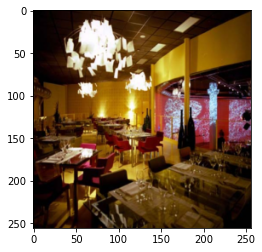

In [18]:
img, label = test_set[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, new_model))

Label: poolinside , Predicted: poolinside


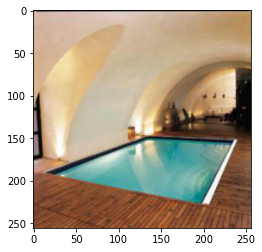

In [19]:
img, label = test_set[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, new_model))